<a href="https://colab.research.google.com/github/monasolgi/DeepLearning/blob/master/gcn_seg_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
npz_data=np.load('/content/drive/MyDrive/Datasets/amazon_electronics_computers (1).npz')
npz_data.files


['adj_data',
 'adj_indices',
 'adj_indptr',
 'adj_shape',
 'attr_data',
 'attr_indices',
 'attr_indptr',
 'attr_shape',
 'labels',
 'class_names']

In [ ]:
 npz_data['labels'].shape
 npz_data['class_names']


array(['Desktops', 'Data Storage', 'Laptops', 'Monitors',
       'Computer Components', 'Video Projectors', 'Routers', 'Tablets',
       'Networking Products', 'Webcams'], dtype='<U19')

In [ ]:
#utils
import numpy as np
import scipy.sparse as sp
import torch
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, normalize



features = sp.csr_matrix((npz_data['attr_data'], npz_data['attr_indices'], npz_data['attr_indptr']),
                                        shape=npz_data['attr_shape'])
  
adj= sp.coo_matrix(sp.csr_matrix((npz_data['adj_data'], npz_data['adj_indices'], npz_data['adj_indptr']),
                                   shape=npz_data['adj_shape']))
features[0]
adj.toarray()[0]


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
#utils
import numpy as np
import scipy.sparse as sp
import torch
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, normalize


def load_data():

 features = sp.csr_matrix((npz_data['attr_data'], npz_data['attr_indices'], npz_data['attr_indptr']),
                                        shape=npz_data['attr_shape'])
  
 adj= sp.coo_matrix(sp.csr_matrix((npz_data['adj_data'], npz_data['adj_indices'], npz_data['adj_indptr']),
                                   shape=npz_data['adj_shape']))
  

 labels=npz_data['labels']
 labels=binarize_labels(labels)

 adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
 adj = normalize(adj + sp.eye(adj.shape[0]))

 idx_train = range(9100)
 idx_val = range(9100,11500)
 idx_test = range(11500, 13381)

 idx_train = torch.LongTensor(idx_train)
 idx_val = torch.LongTensor(idx_val)
 idx_test = torch.LongTensor(idx_test)

 features = torch.FloatTensor(np.array(features.todense()))
 labels = torch.LongTensor(np.where(labels)[1])
 adj = sparse_mx_to_torch_sparse_tensor(adj)

 
 return adj, features, labels, idx_train, idx_val, idx_test
 

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    #sum in every row 
    r_inv = np.power(rowsum, -1).flatten()
    # every sum to the power of -1 
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    #diagonal matrice 
    mx = r_mat_inv.dot(mx)
    return mx


def binarize_labels(labels, sparse_output=False, return_classes=False):
    if hasattr(labels[0], '__iter__'):  # labels[0] is iterable <=> multilabel format
        binarizer = MultiLabelBinarizer(sparse_output=sparse_output)
    else:
        binarizer = LabelBinarizer(sparse_output=sparse_output)
    label_matrix = binarizer.fit_transform(labels).astype(np.float32)
    return (label_matrix, binarizer.classes_) if return_classes else label_matrix
 

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)    


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)    


In [ ]:
#layers

import math

import torch

from torch.nn.parameter import Parameter

#class parameter ,param haro cache mikone

from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        
        #Sparse matrix multiplication=spmm
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ') '

In [ ]:
#models
import torch.nn as nn
import torch.nn.functional as F
#from layers import GraphConvolution


class GCN(nn.Module):
    def __init__(self, nfeat, nhid,nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
   
        self.dropout = dropout
        
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)


In [ ]:
#pip install ipdb


Epoch: 0001 loss_train: 3.0367 acc_train: 0.0725 loss_val: 2.8156 acc_val: 0.1208 time: 0.2399s
Epoch: 0002 loss_train: 2.8491 acc_train: 0.0968 loss_val: 2.5085 acc_val: 0.1125 time: 0.4803s
Epoch: 0003 loss_train: 2.5390 acc_train: 0.1108 loss_val: 2.3669 acc_val: 0.3675 time: 0.7300s
Epoch: 0004 loss_train: 2.3643 acc_train: 0.3526 loss_val: 2.2631 acc_val: 0.3596 time: 0.9843s
Epoch: 0005 loss_train: 2.2676 acc_train: 0.3488 loss_val: 2.3088 acc_val: 0.1846 time: 1.2309s
Epoch: 0006 loss_train: 2.3249 acc_train: 0.2059 loss_val: 2.0828 acc_val: 0.3746 time: 1.4713s
Epoch: 0007 loss_train: 2.1159 acc_train: 0.3714 loss_val: 1.9507 acc_val: 0.3629 time: 1.7352s
Epoch: 0008 loss_train: 1.9587 acc_train: 0.3605 loss_val: 1.9709 acc_val: 0.3713 time: 1.9779s
Epoch: 0009 loss_train: 1.9890 acc_train: 0.3613 loss_val: 1.9931 acc_val: 0.3696 time: 2.2257s
Epoch: 0010 loss_train: 1.9850 acc_train: 0.3602 loss_val: 1.9487 acc_val: 0.3688 time: 2.4744s
Epoch: 0011 loss_train: 1.9506 acc_train

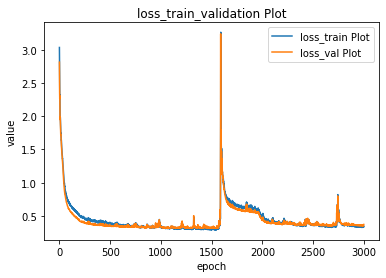

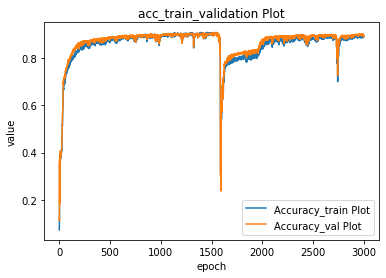

Optimization Finished!
Total time elapsed: 740.2010s
GCN(
  (gc1): GraphConvolution (767 -> 16) 
  (gc2): GraphConvolution (16 -> 10) 
)
Test set results: loss= 0.3854 accuracy= 0.8809


In [ ]:
#train

from __future__ import division
from __future__ import print_function
from torchsummary import summary

import time
import argparse
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import torch.nn.functional as F
import torch.optim as optim
#from utils import load_data, accuracy
#from models import GCN

# Training settings

parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=3000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')

parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')

#args = parser.parse_args()
#error midad khate bala,khate paein jaigozin shod

args = parser.parse_known_args()[0]

args.cuda = not args.no_cuda and torch.cuda.is_available()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data

adj, features, labels, idx_train, idx_val, idx_test = load_data()

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=10,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)


## to set cuda as your device if possible
##training on  GPU

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    
    ## train:adjust the weights on the neural network
    ## validation:used to minimize overfitting
 
def test():
    ## Turn on evaluation mode which disables dropout.
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

def train(epoch):
  model.train()
  optimizer.zero_grad()
  output = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  acc_train = accuracy(output[idx_train], labels[idx_train])
  # Computing the gradients necessary to adjust the weights
  loss_train.backward()
  # Updating the weights of the neural network
  optimizer.step()
  losses.append(loss_train.item())
  acc.append(acc_train.item())

  if not args.fastmode:
    # Evaluate validation set performance separately,
    # deactivates dropout during validation run.
    model.eval()
    output = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])
  acc_val = accuracy(output[idx_val], labels[idx_val])
  losses_val.append(loss_val.item())
  acc_valid.append(acc_val.item())

  print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

# Train model
t_total = time.time()
losses = []
acc=[]
losses_val = []
acc_valid=[]
t = time.time()
for epoch in range(args.epochs):
    train(epoch)

plt.plot(np.array(losses),label ='loss_train Plot')#plotting loss_train_val
plt.plot(np.array(losses_val),label ='loss_val Plot')
plt.title('loss_train_validation Plot')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

plt2.plot(np.array(acc),label ='Accuracy_train Plot')#plotting acc_train_val
plt2.plot(np.array(acc_valid),label ='Accuracy_val Plot')
plt2.title('acc_train_validation Plot')
plt2.xlabel('epoch')
plt2.ylabel('value')
plt2.legend()
plt2.show()    

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

print(model)
#summary(model,[(13381,767),(13381,13381)])
# Testing
test()


